In [1]:
from scipy.io import loadmat
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import numpy as np
import math

Reading the MNIST dataset and the weitghts
The weights come from a given trained NN and is used for evaluation

In [2]:
X = loadmat('ex4data1.mat')['X']
Y = loadmat('ex4data1.mat')['y'].flatten()
num_labels = 10
weights = loadmat('ex4weights.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

Visualising the dataset

In [3]:
def mnist_visualizer(x):
    '''
    imput is a (400,) array representing an mnist sample
    Converts the sample to (20,20) data and plots the sample number
    '''
    y = np.empty(shape =(20,20))
    for irow in range (20):
        y[irow,:] = x[20*irow:20*(irow+1)]
    w = 4
    h = 3
    d = 70
    plt.figure(figsize=(w, h), dpi=d)
    color_map = plt.imshow(np.transpose(y))
    color_map.set_cmap("Blues_r")
    plt.colorbar()

(5000,)

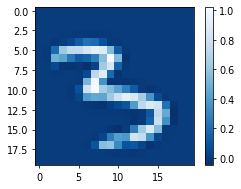

In [4]:
mnist_visualizer(X[1700])
Y.shape

In [5]:
def sigmoid (x):
    if type (x) == np.ndarray:
        return 1/(1 + np.exp(-x))
    else:
        return 1/(1+math.exp(-x))

Setting up number of layers and neurons

In [6]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  
hidden_layer_size = 25   
num_labels = 10         
lamda = 1
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

Encoding y to to a 10*1 vector 

In [7]:
def encode_y (Y,num_labels):
    encoded_y = np.zeros (shape= (Y.shape[0], num_labels))
    for i,row in enumerate (encoded_y[:]):
        row[Y[i]-1] = 1
    return encoded_y

In [8]:
y_encoded = encode_y (Y, num_labels)

In [9]:
def sigmoidGradient (x):
    if type (x) == np.ndarray:
        sig_grad = sigmoid (x) * ( 1 - sigmoid(x) )
        return sig_grad
    else:
        sig_grad = sigmoid (x) * ( 1 - sigmoid(x) )
        return sig_grad

#Random initialization

In [10]:
def rand_initialize_weights (l_input, l_output, eps=0.12):
    theta = np.random.rand(l_output, 1 + l_input) * 2 * eps - eps
    return theta

In [11]:
initial_Theta1 = rand_initialize_weights(input_layer_size, hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()], axis=0)

Computing the cost and the gradient for a given set of parameters 
(for 1 epoch)

In [14]:
def nn_cost  (nn_params,
              input_layer_size,
              hidden_layer_size,
              num_labels,
              X, y, lamda=0
             ):
    m = X.shape[0]
    #Reshaping Theta1  and Theta 2 to matrix form from nn_params
    Theta1 = np.reshape( nn_params[:(input_layer_size + 1)*hidden_layer_size],
                        (hidden_layer_size,input_layer_size+1) )
    Theta2 = np.reshape( nn_params[(input_layer_size+1)*hidden_layer_size:],
                        (num_labels,hidden_layer_size+1) )
    #Forward propagation to get h_theta 
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = sigmoid( X @  np.transpose(Theta1)  ) 
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    h_theta_i_k = sigmoid( a2 @   np.transpose(Theta2) )
    #h_theta_i_k is the last layer
    #calculate the cost of the network
    one = np.ones (shape= h_theta_i_k.shape)
    a = y * np.log (h_theta_i_k)
    b = (one - y) * np.log (one - h_theta_i_k)
    cost = 1/m * sum (sum (-a-b))
    #Regularized cost
    cost += ( sum (sum ( (Theta1*Theta1)[:,1:] ) ) + 
             sum (sum ( (Theta2*Theta2)[:,1:] ) ) ) * lamda / (2*m)
    Delta_2, Delta_1 = 0,0
    #Gard calculation 
    for t in range (m):
        a1 = X[t,:] #401
        a1 = np.reshape(a1,(a1.size,1))
        #forward propagation
        z2 = Theta1 @  a1
        a2 = sigmoid (z2)
        a2 = np.insert (a2,0,1,axis=0) #26
        z3 = Theta2 @ a2
        a3 = sigmoid (z3) #10
        
        delta_3 = a3 - y[t].reshape(y[t].size,1) #10
        delta_2 = ( np.transpose(Theta2) @ delta_3 ) * sigmoidGradient(np.insert (z2,0,1,axis=0))
        delta_2 = delta_2 [1:,:]

        Delta_2 += delta_3 @ np.transpose(a2)
        Delta_1 += delta_2 @ np.transpose(a1)

    grad_1 = 1/m * Delta_1
    grad_2 = 1/m * Delta_2

    #Reugularized gradient
    grad_1 += (lamda/m) * sum ( sum ( Theta1[:,1:] ) )
    grad_2 += (lamda/m) * sum ( sum ( Theta2[:,1:] ) )
    grad = np.concatenate([grad_1.ravel(), grad_2.ravel()])

    return cost,grad

Training the network for different lamdas to see which gives the lowest cost

In [22]:
global costs
trial_lamdas = range(1,20,2)
trial_lamdas = [item / 10 for item in trial_lamdas ]
lamda_costs = []
for i,lamda in enumerate (trial_lamdas):
    
    costs = []
    options= {'maxiter': 200}
    costFunction = lambda p: nn_cost(p, input_layer_size,
                                            hidden_layer_size,
                                            num_labels, X, y_encoded, lamda)
    res = optimize.minimize(costFunction,
                            initial_nn_params,
                            jac=True,
                            method='TNC',
                            options=options)
    print(f'lamda{lamda}')
    lamda_costs.append([lamda,costs])

lamda0.1


<ipython-input-14-ff19993c6620>:22: RuntimeWarning: divide by zero encountered in log
  b = (one - y) * np.log (one - h_theta_i_k)
<ipython-input-14-ff19993c6620>:22: RuntimeWarning: invalid value encountered in multiply
  b = (one - y) * np.log (one - h_theta_i_k)


lamda0.3
lamda0.5
lamda0.7
lamda0.9
lamda1.1
lamda1.3
lamda1.5
lamda1.7
lamda1.9


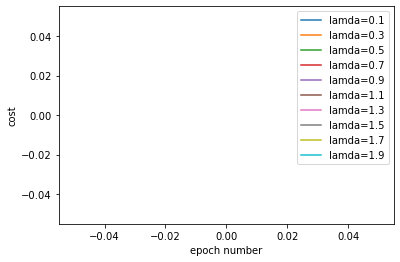

In [23]:
for i,lamda in enumerate (trial_lamdas):
    plt.plot ( range(len(lamda_costs[i][1]) ) ,lamda_costs[i][1],label='lamda='+str(lamda_costs[i][0]) ) 
    plt.xlabel ('epoch number')
    plt.ylabel ('cost')
    plt.legend()

Lamda=1 is the best regularization parameter
The network is trained using lamda=1

In [24]:
lamda = 1
options= {'maxiter': 200}
costFunction = lambda p: nn_cost(p, input_layer_size,
                                    hidden_layer_size,
                                    num_labels, X, y_encoded, lamda)
res = optimize.minimize(costFunction,
                        initial_nn_params,
                        jac=True,
                        method='TNC',
                        options=options)
trained_params = res.x

In [25]:
def predict(nn_paramss,input_layer_size, hidden_layer_size,num_labels , X):
    #Reshaping Theta1  and Theta 2 to matrix form from nn_params
    Theta1 = np.reshape( nn_paramss[:(input_layer_size + 1)*hidden_layer_size],
                        (hidden_layer_size,input_layer_size+1) )
    Theta2 = np.reshape( nn_paramss[(input_layer_size+1)*hidden_layer_size:],
                        (num_labels,hidden_layer_size+1) )
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    p = np.zeros(X.shape[0])
    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    a2 = sigmoid( X @  np.transpose(Theta1)  ) 
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    probs = sigmoid( a2 @   np.transpose(Theta2) )
    p = np.argmax(probs, axis = 1)
    return probs,p

Checking the trainning set accuracy

In [26]:
probs,pred = predict(trained_params,input_layer_size, hidden_layer_size,num_labels , X)
pred = pred + 1
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == Y) * 100))

Training Set Accuracy: 91.6%


Visualizing a predicted value

pred[600] is 1


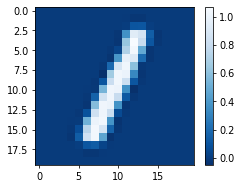

In [27]:
print (f'pred[600] is {pred[600]}')
mnist_visualizer (X[600])